In [1]:
# Läser in paket 
# Import needed libraries
import tensorflow as tf


import os
import glob
import cv2

import numpy as np

# from tensorflow import keras
# from tensorflow.keras import layers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D,MaxPooling2D,Dropout, Input, Concatenate, Lambda, GlobalAveragePooling2D
from tensorflow.keras.utils  import to_categorical

#print('Keras version:',tf.keras.__version__)

# Helper libraries

import sklearn
from   sklearn.model_selection import train_test_split

# Matlab plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#earlystopping
from keras.callbacks import EarlyStopping

# importerar funktioner för att skapa förväxlingsmatriser
from sklearn.metrics import   ConfusionMatrixDisplay, confusion_matrix


import keras_tuner

# Baysian tuner för att hitta bra hyperparametrar
from keras_tuner.tuners import BayesianOptimization



# Läser in 2 färdiga modeller
from tensorflow.keras.models import Model
from tensorflow.keras.applications import  VGG16
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2


from tensorflow.keras.preprocessing.image import ImageDataGenerator


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Tomma listor som ska fyllas med bilder och klasser
train_images = []
train_labels = [] 

for directory_path in glob.glob("/kaggle/input/fruit-recognition/train/train/*"):
    label = directory_path.split("/")[-1] 
    #print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)

In [3]:
img_dir="/kaggle/input/fruit-recognition/train/train/"
# Plockar ut antal klasser
classes = []
for i in os.listdir(img_dir):
    classes.append(i)

num_classes = len(classes)
print('Klasserna i datamaterialet är :',classes)

Klasserna i datamaterialet är : ['Orange', 'Tomato', 'Passion Fruit', 'Cucumber Ripe', 'Cactus fruit', 'Pomegranate', 'Plum', 'Pineapple', 'Papaya', 'Potato Red', 'Kiwi', 'Limes', 'Apple Braeburn', 'Pear', 'Onion White', 'Strawberry', 'Grape Blue', 'Blueberry', 'Apple Granny Smith', 'Apricot', 'Pepper Red', 'Clementine', 'Lemon', 'Avocado', 'Raspberry', 'Cantaloupe', 'Peach', 'Corn', 'Banana', 'Cherry', 'Pepper Green', 'Watermelon', 'Mango']


In [4]:
# Normalize the images.
train_images = (train_images - np.min(train_images)) / (np.max(train_images) - np.min(train_images))

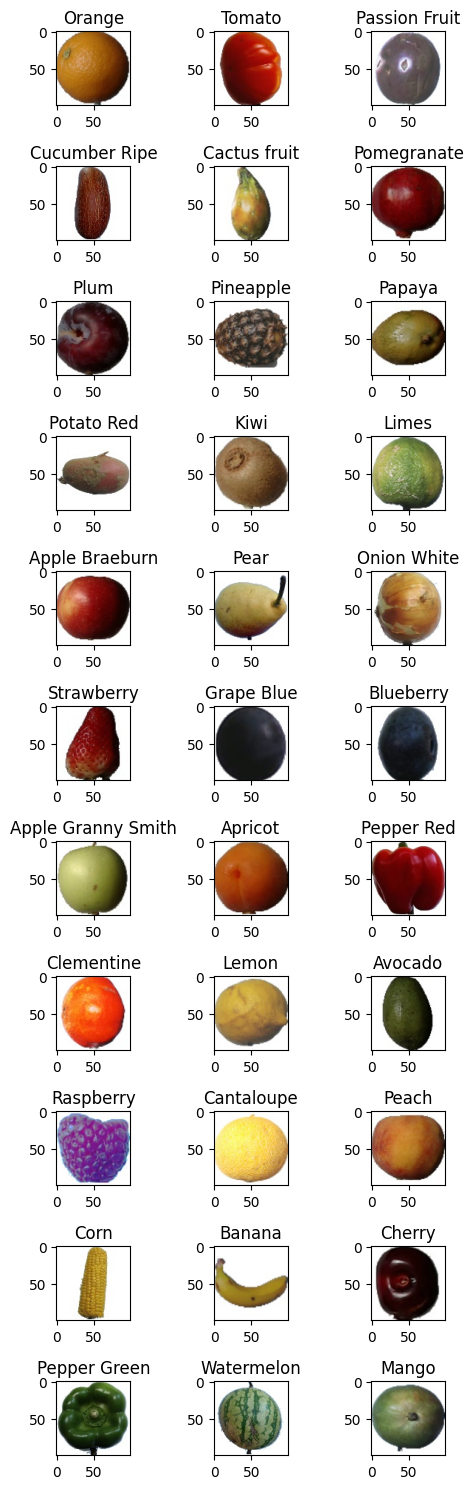

In [5]:

# Kod för att printa alla frukter med tillhörande namn
fig = plt.figure(figsize=(5, 15)) # Sätter storlek och räknare 
k = 0
for frukt in classes: 
    for file in os.listdir(img_dir+"/"+frukt)[0:1]: 
        img=mpimg.imread(img_dir+"/"+frukt+"/"+file)
        #plt.figure()
        k=k+1
        plt.subplot(11,3,k) 
        plt.title(frukt)
        plt.imshow(img)
plt.tight_layout() # ändrar avståndet mellan bilderna

Bilderna är av olika kvalitet, vissa är lätta att urskilja med ögat men andra är relativt svåra, detta kommer möjligtvis göra det lite svårare för en modell att lyckas hitta mönster som skiljer dem åt. Till exempel är blåbär och blåa vindruvor väldigt lika för bilderna som printats ovan.

In [6]:
# Delar upp träningsdata till valideringsmängd , där 60% är träning och 40% validering.

train_images = np.array(train_images)
train_labels = np.array(train_labels)

train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.40)


In [7]:
val_images, test_images, val_labels, test_labels = train_test_split(val_images, val_labels, test_size=0.25)


In [8]:
# Kollar så att det blir 32x32x3
print(train_images.shape)
print(val_images.shape)
print(test_images.shape)


(10112, 100, 100, 3)
(5056, 100, 100, 3)
(1686, 100, 100, 3)


I träningsdatat finns 10112  i träningsmängden, 5056 i valideringsmängden och 1686 i testmängden, bilderna är 100X100.

In [9]:
# Ändrar så datat till de minsta dimensionerna som fungerar på de inlästa modellerna
train_images=tf.image.resize_with_pad(train_images, 72, 72, antialias=False)
val_images=tf.image.resize_with_pad(val_images, 72, 72, antialias=False)
test_images=tf.image.resize_with_pad(test_images, 72, 72, antialias=False)

print(train_images.shape)
print(val_images.shape)
print(test_images.shape)

(10112, 72, 72, 3)
(5056, 72, 72, 3)
(1686, 72, 72, 3)


Stoleken på bilderna har minskats för att ta upp mindre storlek. 

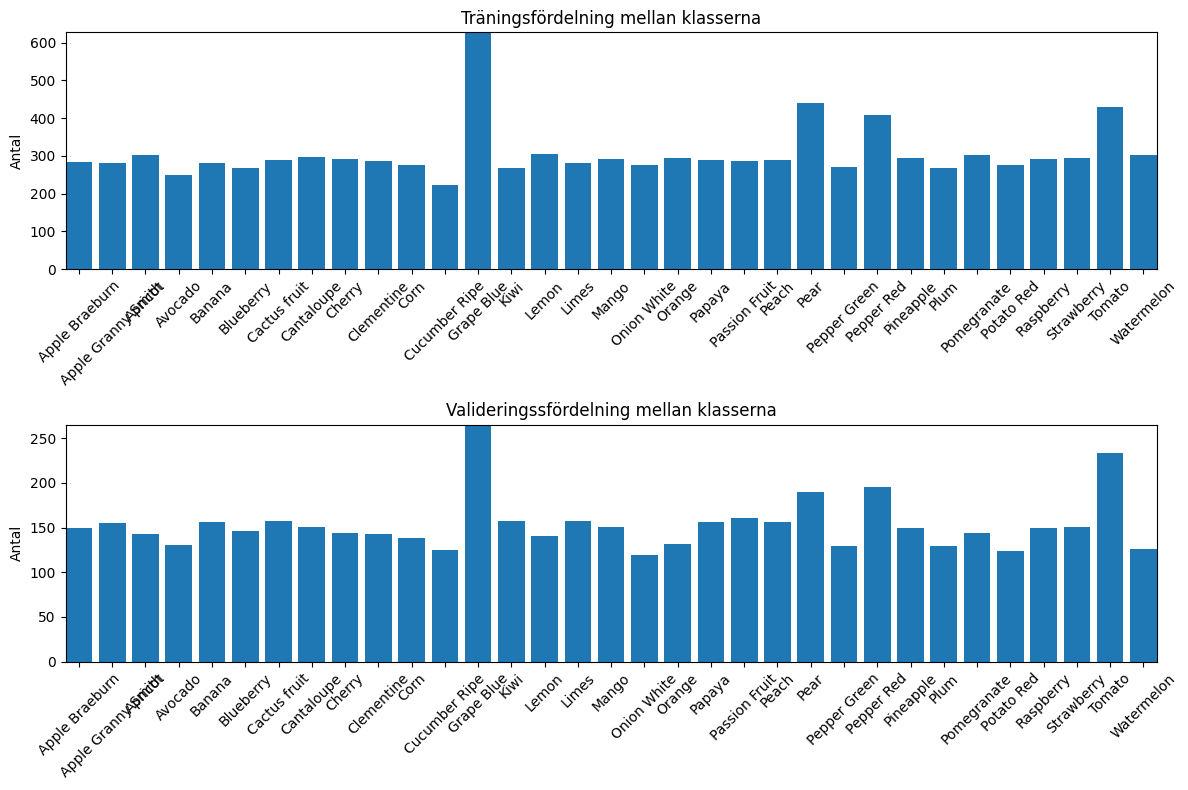

In [10]:
# Printar fördelningen för klasserna inom dataseten

train_label_counts = {}
for label in train_labels:
    if label in train_label_counts:
        train_label_counts[label] += 1
    else:
        train_label_counts[label] = 1

val_label_counts = {}
for label in val_labels:
    if label in val_label_counts:
        val_label_counts[label] += 1
    else:
        val_label_counts[label] = 1

# Sorterar klasserna 
train_label_counts = dict(sorted(train_label_counts.items()))
val_label_counts = dict(sorted(val_label_counts.items()))
        
# Skapar plotsen
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# Plot train_label_counts
ax[0].bar(train_label_counts.keys(), train_label_counts.values())
ax[0].set_title('Träningsfördelning mellan klasserna')
ax[0].set_ylabel('Antal')

ax[0].tick_params(axis='x', rotation=45) 
ax[0].margins(0)

# Plot val_label_counts
ax[1].bar(val_label_counts.keys(), val_label_counts.values())
ax[1].set_title('Valideringssfördelning mellan klasserna')
ax[1].set_ylabel('Antal')

plt.xticks(rotation=45)

plt.tight_layout()
plt.margins(0)

plt.show()

Fördelningen är relativt jämn mellan klasserna så det är förhopningsvis inga problem med att en modell kommer prediktera skevt pga fördelningen. 

In [11]:
input_shape = train_images[0].shape # Sätter en input shape som ska användas vid modellering

In [12]:
from sklearn.preprocessing import LabelEncoder

# Läser in encodern
label_encoder = LabelEncoder()

# Kodar om klasserna till siffror
train_labels = label_encoder.fit_transform(train_labels)
val_labels = label_encoder.transform(val_labels)
test_labels = label_encoder.transform(test_labels)

In [13]:
# VGG16 från keras
vgg_model = tf.keras.applications.vgg16.VGG16(include_top=False, weights="imagenet", input_shape=input_shape,classes=num_classes)

# Tar alla lager fram till block3_pool från VGG16 och fryser deras vikter med trainable=FALSE

# Tar alla lager fram till block3_pool från VGG16 och fryser deras vikter med trainable=FALSE
# Skapar en ny modell som kopierar vgg_modell fram till lager 'block3_pool'
inputs = vgg_model.inputs
my_model = vgg_model.get_layer('block3_pool').output 

# Fryser alla lagren i modellen
#for layer in my_model.layers:
#  layer.trainable = False

# Lägger till egna lager som ska tränas
my_model = tf.keras.layers.BatchNormalization(axis=-1)(my_model) # normaliserar inputs
my_model = Conv2D(filters=96, 
                        kernel_size=5,
                        activation='relu',
                        padding='same')(my_model)

my_model=(tf.keras.layers.Flatten())(my_model)  # Ser till så lagren är 'full connected'
my_model=(tf.keras.layers.Dense(64,activation='relu'))(my_model)  # tagit bort ett lager och minskat filter /noder i dom jag lagt in som är kvar
outputs=(Dense(units=num_classes, activation='softmax'))(my_model) #sista lagret 
my_model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

# Gör så att det går att träna lagren
for layer in my_model.layers:
  layer.trainable = True

# Freeze the layers
for layer in my_model.layers[:-6]:
    layer.trainable = False


my_model.summary()



58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 72, 72, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 72, 72, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 72, 72, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 36, 36, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 36, 36, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 36, 36, 128)       147584    
                                                              

In [14]:
my_model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # ändrat inlärningstakten
  loss='categorical_crossentropy',
  metrics=['categorical_accuracy'],
  
)

earlystop= EarlyStopping(monitor='val_loss', patience=3, restore_best_weights = True) # lägger in earlystopping

epochs = 70 # Antal epoker som kan köras
batch_size = 96 # batchstoleken 

# Train the model.
history = my_model.fit(
  train_images, to_categorical(train_labels),
  epochs=epochs,
  batch_size=batch_size,
  verbose = 1,
  validation_data=(val_images,to_categorical(val_labels)),
  callbacks=[earlystop] # Lägger in earlystopping i träningen
)



Epoch 1/70
106/106 [==============================] - 20s 73ms/step - loss: 0.6431 - categorical_accuracy: 0.8645 - val_loss: 0.0515 - val_categorical_accuracy: 0.9935
Epoch 2/70
106/106 [==============================] - 5s 50ms/step - loss: 0.0152 - categorical_accuracy: 0.9997 - val_loss: 0.0082 - val_categorical_accuracy: 1.0000
Epoch 3/70
106/106 [==============================] - 6s 60ms/step - loss: 0.0056 - categorical_accuracy: 1.0000 - val_loss: 0.0043 - val_categorical_accuracy: 1.0000
Epoch 4/70
106/106 [==============================] - 5s 50ms/step - loss: 0.0032 - categorical_accuracy: 1.0000 - val_loss: 0.0028 - val_categorical_accuracy: 1.0000
Epoch 5/70
106/106 [==============================] - 5s 51ms/step - loss: 0.0021 - categorical_accuracy: 1.0000 - val_loss: 0.0020 - val_categorical_accuracy: 1.0000
Epoch 6/70
106/106 [==============================] - 5s 50ms/step - loss: 0.0015 - categorical_accuracy: 1.0000 - val_loss: 0.0015 - val_categorical_accuracy: 1.00

In [15]:

# Evaluate the model.
test_loss, test_acc = my_model.evaluate(test_images,to_categorical(test_labels))
print('Test accuracy: %.3f' % test_acc)

53/53 [==============================] - 1s 24ms/step - loss: 1.5265e-05 - categorical_accuracy: 1.0000
Test accuracy: 1.000
